In [1]:
import pandas as pd
import numpy as np
from scipy.special import factorial
pd.set_option('display.max_rows', 512)

class moms: None
class par: None

In [2]:
estimates = pd.DataFrame(index=["beta","mu","p","delta","alpha","g_L","g_Z","g_Q","N_bar"])
estimates.index.name = "Name"
estimates["1984 - 2000"] = [0.9548656838699158,
 1.1675210747182811,
 0.04230663870241839,
 0.011917068212522535,
 0.29172199376368735,
 0.011039519618215962,
 0.020616474535254697,
 0.018525793406463327,
 0.47711467112289013]
estimates["2001 - 2016"] = [0.9738197786327719,
 1.196272565262089,
 0.048723228282233515,
 0.05591055103386153,
 0.2989387256531002,
 0.008792808430872934,
 0.00932770527191295,
 0.00745007857774263,
 0.4758647281618627]

In [3]:
#Find all possible orders of changing parameters, cf. p 178
import itertools
l_permutation = list(itertools.product([0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1]))
df_permutation = pd.DataFrame(l_permutation,columns = ['beta','mu','p','delta','alpha','g_L','g_Z','g_Q','N_bar'])
df_permutation["permsum"] = df_permutation.sum(axis=1)

In [4]:
#arr = np.array(df_permutation["permsum"])
#brr = 9-np.array(df_permutation["permsum"]+1)
#df_permutation["w_help"] = (factorial(arr)*factorial(brr))/factorial(9)

#for i in [1,2,3,4,5,6,7,8,9]:
#    parm = ["beta","mu","p","delta","alpha","g_L","g_Z","g_Q","N_bar"]
    
#    par = parm[i-1]    
#    name = "w_" + par
    
#    w_i = df_permutation[df_permutation[par]==0]["w_help"] # Udvælg de 256 værdier, hvor par = 0
#    w_i2 = w_i.copy() # Lav kopi
#    w_i2.index = w_i2.index + (512/2**i) # Skub index i kopien med 512 / 2^i. 
#    w_i3 = w_i.append(w_i2) # Sæt sammen. OBS – vigtigt at ignore_index ikke sættes til True!
#    df_permutation[name] = w_i3 # Gem vægtkolonnen for dette parameter i datasæt. Den ganges på inden periode 2 og 1 trækkes fra hinanden, når vi tager conditional mean (nu sum).

In [6]:
#Assumptions and settings
def misc(par,moms):
    par.b = -np.log(1-0.15)
    par.bh = -np.log(1+0.15)
    par.sigma = 0.5
    par.theta = 12
    par.g_T = (1+par.g_L)*(1+par.g_Z)**(1/(1-par.alpha))*(1+par.g_Q)**(par.alpha/(1-par.alpha)) - 1
    par.g_PC = (1+par.g_T)/(1+par.g_L) - 1   
    par.MOM2 = ((1-2*par.p)+par.p*np.exp(-par.bh*(1-par.theta)) + par.p*np.exp(-par.b*(1-par.theta)))
    par.MOM3 = ((1-2*par.p)+par.p*np.exp(-par.bh*(-par.theta)) + par.p*np.exp(-par.b*(-par.theta))) 
    par.MOM = (par.MOM2)**((1-par.sigma)/(1-par.theta))  
    par.beta_star = par.beta * (1+par.g_PC)**(-par.sigma) * par.MOM

#Define equations as functions of parameters only
def growthpop(par,moms):
    return par.g_L

def priceinvt(par,moms):
    return -par.g_Q

def ik(par,moms):
    return (1+par.g_Q)*(1+par.g_T)-(1-par.delta)

def EmpPop(par,moms):
    return par.N_bar

def ProfitY(par,moms):
    return (par.mu+par.alpha-1)/(par.mu)

def TFPgrowth(par,moms):
    misc(par,moms)
    moms.ProfitY = (par.mu+par.alpha-1)/(par.mu)
    return par.g_T-(1-moms.ProfitY)*par.g_L-moms.ProfitY*(par.g_T+par.g_Q)

def ProfitK(par,moms):
    misc(par,moms)
    r_star = 1/par.beta_star - 1
    return ((par.mu + par.alpha -1)/(par.alpha))*(r_star + par.delta + par.g_Q*(1+r_star))

def RF(par,moms):
    misc(par,moms)
    return par.MOM2/(par.MOM3*par.beta_star)-1

def PD(par,moms):
    misc(par,moms)
    return (par.beta_star*(1+par.g_T)/(1-par.beta_star*(1+par.g_T)))


In [7]:
#Vary all parameters one by one and store values. 
result = [(ProfitK(par,moms),ProfitY(par,moms),RF(par,moms), growthpop(par,moms), priceinvt(par,moms),PD(par,moms), TFPgrowth(par,moms), ik(par,moms), EmpPop(par,moms))
            for par.beta in [estimates.loc["beta","1984 - 2000"],estimates.loc["beta","2001 - 2016"]]
            for par.mu in [estimates.loc["mu","1984 - 2000"],estimates.loc["mu","2001 - 2016"]]
            for par.p in [estimates.loc["p","1984 - 2000"],estimates.loc["p","2001 - 2016"]]
            for par.delta in [estimates.loc["delta","1984 - 2000"],estimates.loc["delta","2001 - 2016"]]
            for par.alpha in [estimates.loc["alpha","1984 - 2000"],estimates.loc["alpha","2001 - 2016"]]
            for par.g_L in [estimates.loc["g_L","1984 - 2000"],estimates.loc["g_L","2001 - 2016"]]
            for par.g_Z in [estimates.loc["g_Z","1984 - 2000"],estimates.loc["g_Z","2001 - 2016"]]
            for par.g_Q in [estimates.loc["g_Q","1984 - 2000"],estimates.loc["g_Q","2001 - 2016"]]
            for par.N_bar in [estimates.loc["N_bar","1984 - 2000"],estimates.loc["N_bar","2001 - 2016"]]
         ]
df = pd.DataFrame(result, columns =["ProfitK","ProfitY","RF", "growthpop","priceinvt","PD","TFPgrowth","ik","EmpPop"])

In [8]:
#Join with df of all possible orders from above
df = df_permutation.join(df)

In [9]:
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 100)
#df

In [10]:
moments = ["ProfitK","ProfitY","RF","PD","ik","TFPgrowth","priceinvt","growthpop","EmpPop"]
parameters = ["beta","mu","p","delta","alpha","g_L","g_Z","g_Q","N_bar"]

#for moment in ["ProfitK","ProfitY","RF","PD","ik","TFPgrowth","priceinvt","growthpop","EmpPop"]:
#    df[moment] = df[moment].multiply(df["w_beta"])

df_results = pd.DataFrame(columns=parameters)
df_results["moment"] = moments
df_results = df_results.set_index("moment",drop=True)

#Take means of all possible orders, conditional on one parameter. 
for mom in moments:
    for parm in parameters:
        result = (df.loc[(df[parm] == 1),mom].mul(df["w_"+parm]).sum()-df.loc[(df[parm] == 0),mom].mul(df["w_"+parm]).sum())
        df_results.loc[mom,parm] = result    

#Print and format results.
df_results_formatted = df_results.copy()        
df_results_formatted = df_results_formatted.astype(float) # Convert all to floats (they appear to be strings?)
df_results_formatted['sum'] = df_results_formatted.sum(axis=1, skipna=True)    # Sum rows  
#df_results_formatted['p2'] = [moms.ProfitK,moms.s_K,moms.RF,moms.PD,moms.ik,moms.TFPgrowth,moms.g_Q,moms.g_L,moms.N_bar]
#df_results_formatted['p1'] = df_results_formatted['p2']-df_results_formatted['change']
#df_results_formatted = df_results_formatted[["p1","p2","change","beta","mu","p","delta","alpha","g_L","g_Z","g_Q","N_bar"]] # Change order – sum first


# Multiply all, except for PD, by 100
scalar = [1 if i=="PD" else 100 for i in df_results_formatted.index.tolist()]  #Create list, 1 for PD, 100 for all other
df_results_formatted = df_results_formatted.multiply(scalar,axis=0)

# Round and set padding zeros
for var in df_results_formatted.columns.tolist()[:]:
    df_results_formatted[var] = df_results_formatted[var].map('${:,.2f}$'.format)

### Our result of decomposition

In [11]:
df_results_formatted

,beta,mu,p,delta,alpha,g_L,g_Z,g_Q,N_bar,sum
moment,,,,,,,,,,
ProfitK,$-3.41$,$1.04$,$0.18$,$7.11$,$-0.13$,$-0.00$,$-1.37$,$-2.29$,$0.00$,$1.13$
ProfitY,$0.00$,$1.45$,$0.00$,$0.00$,$0.61$,$0.00$,$0.00$,$0.00$,$0.00$,$2.06$
RF,$-2.00$,$0.00$,$-0.35$,$0.00$,$0.02$,$-0.00$,$-0.80$,$-0.23$,$0.00$,$-3.37$
PD,$80.53$,$0.00$,$-5.69$,$0.00$,$1.33$,$-11.96$,$-37.32$,$-12.31$,$0.00$,$14.59$
ik,$0.00$,$0.00$,$0.00$,$4.40$,$0.04$,$-0.23$,$-1.66$,$-1.63$,$0.00$,$0.92$
TFPgrowth,$0.00$,$-0.06$,$0.00$,$0.00$,$0.00$,$-0.00$,$-0.98$,$0.16$,$0.00$,$-0.87$
priceinvt,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$1.11$,$0.00$,$1.11$
growthpop,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$-0.22$,$0.00$,$0.00$,$0.00$,$-0.22$
EmpPop,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$0.00$,$-0.12$,$-0.12$


### Result using Farhi & Gourios MatLab-file

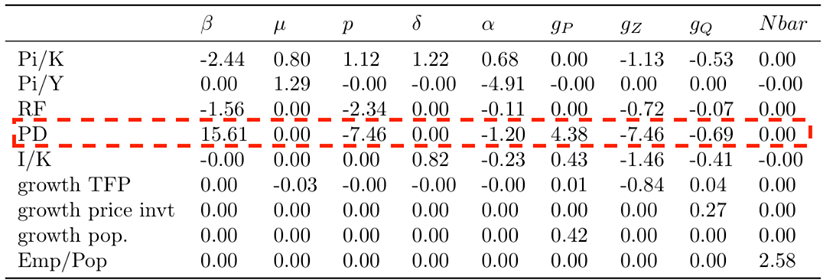

In [12]:
from IPython.display import Image
Image("https://www.norgaardpetersen.dk/assets/PD.png")